In [1]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt

from snntorch import surrogate
from snntorch.functional import ce_rate_loss
from tqdm import tqdm

from data_processing.dataloader import DataParam, LoaderCreator
from modules.lsm_hyperparam import LSMNeuronParams
from modules.lsm_net import *
from trainers.trainer import OptmParams, Trainer
from data_processing.dataloader import AudioMNIST

In [2]:
torch.cuda.is_available()

False

In [3]:
print(torch.__version__)

1.13.1


In [4]:
def build_env(read_checkpoint = False, num_epoch = 100):
    
    #device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    device = torch.device("cpu")
    
    train_param = DataParam(0.8, 128, shuffle=True)
    val_param = DataParam(0.12, 16, shuffle=False)
    test_param = DataParam(0.08, 32, shuffle=False)

    train_dl, val_dl, test_dl = LoaderCreator('./SpikeData/').create_loaders(
        train_param,
        val_param,
        test_param)

    seed = 12345
    weight_bit = 6
    volt_bit = 8
    weight_max = 2 ** weight_bit - 1
    threshold_max = 2 ** volt_bit - 1
    num_steps = 128
    t_decay = 10
    param = LSMInitParams(in_size=19, hidden_size=60, out_size=10, seed=seed, fan_in=16, inhib=10)
    weights = LSMNeuronParams(wlo=0.5, whi=10, tlo=8, thi=threshold_max)
    optm = OptmParams(grad=surrogate.fast_sigmoid(), num_steps=num_steps, lr=5e-1, beta_lo=1 - 1e-1, beta_hi=1 - 1e-3)
    init = LSMInitializer(param, weights)
    stdp = STDPLearner(ap=0.0006, an=0.0005, tp=t_decay, tn=t_decay, wmax=weight_max, wmin=0.5)
    net = LSMPool(optm, param, init, stdp).to(device)

    def transform(_, x):
        return x.permute((2, 0, 1))
    
    trainer = Trainer(net, optm, ce_rate_loss(), transform)
    

    w0 = net.fc1.weight.data.clone().to(device)

    checkpoint = "./Checkpoints"
    if not os.path.isdir(checkpoint):
        os.mkdir(checkpoint)
  
    
    if not read_checkpoint:
        for j in range(4):
            epochs = tqdm(iter(train_dl))
            print("LSM Starts")
            #
            print(j)
            for i, (data, target) in enumerate(epochs):
                net.lsm_train(transform(0, data))
                w1 = net.fc1.weight.data.clone().to(device)

                acvtivity = stdp.step() / 2
                variation = torch.sum(torch.square(w0 - w1))
                connected = torch.sum(w1 != 0)
                epochs.set_description(f"LSM activity: {acvtivity} | variation: {variation:.3f} | connected: {connected}")
                w0 = w1

                torch.save(net.state_dict(), f"{checkpoint}/lsm_stdp_{i}.pth")

    else:
        net.load_state_dict(torch.load(f"{checkpoint}/lsm_stdp_{749}.pth"))
    
    #device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    
    trainer.train(num_epoch, train_dl, test_dl)

    # net.lsm_train()
    # net.forward()

In [8]:
if __name__ == "__main__":
    build_env(False,50)

100%|██████████| 10/10 [00:00<00:00, 114.59it/s]

rebuilding data!
Trainer Constructed. Device:  cpu



  0%|          | 0/188 [00:00<?, ?it/s]

LSM Starts
0


LSM activity: 18346.0 | variation: 10.641 | connected: 764: 100%|██████████| 188/188 [00:40<00:00,  4.70it/s] 
  0%|          | 0/188 [00:00<?, ?it/s]

LSM Starts
1


LSM activity: 20772.5 | variation: 1.610 | connected: 613: 100%|██████████| 188/188 [00:39<00:00,  4.76it/s]  
  0%|          | 0/188 [00:00<?, ?it/s]

LSM Starts
2


LSM activity: 19890.0 | variation: 1.644 | connected: 548: 100%|██████████| 188/188 [00:40<00:00,  4.66it/s] 
  0%|          | 0/188 [00:00<?, ?it/s]

LSM Starts
3


LSM activity: 21974.5 | variation: 0.476 | connected: 524: 100%|██████████| 188/188 [00:40<00:00,  4.61it/s] 
Step: 49 | Evaluate Testing Set: 75/75 | loss: 2.303e+00 | Training Set Accuracy: 9.90% | Testing Set Accuracy: 10.00%: 100%|██████████| 50/50 [1:20:46<00:00, 96.93s/it]    

[0.09883333333333333, 0.09883333333333333, 0.098875, 0.098875, 0.09895833333333333, 0.09891666666666667, 0.09891666666666667, 0.09858333333333333, 0.098875, 0.09879166666666667, 0.09879166666666667, 0.09875, 0.098875, 0.098875, 0.09891666666666667, 0.096375, 0.09883333333333333, 0.09854166666666667, 0.099375, 0.099, 0.099, 0.099, 0.099, 0.099, 0.099, 0.099, 0.099, 0.099, 0.099, 0.099, 0.09904166666666667, 0.09904166666666667, 0.09904166666666667, 0.09908333333333333, 0.10025, 0.09904166666666667, 0.09908333333333333, 0.09895833333333333, 0.09895833333333333, 0.09895833333333333, 0.09895833333333333, 0.09895833333333333, 0.09895833333333333, 0.09895833333333333, 0.09991666666666667, 0.09908333333333333, 0.099125, 0.09916666666666667, 0.10091666666666667, 0.099]
[0.10083333333333333, 0.10083333333333333, 0.10083333333333333, 0.10083333333333333, 0.10083333333333333, 0.10083333333333333, 0.10083333333333333, 0.09958333333333333, 0.1, 0.10041666666666667, 0.1, 0.10041666666666667, 0.100416

In [9]:
if __name__ == "__main__":
    build_env(True,30)

  0%|          | 0/30 [00:00<?, ?it/s]

rebuilding data!
Trainer Constructed. Device:  cpu


Step: 29 | Evaluate Testing Set: 75/75 | loss: 2.302e+00 | Training Set Accuracy: 18.53% | Testing Set Accuracy: 18.58%: 100%|██████████| 30/30 [37:56<00:00, 75.89s/it]   

[0.10358333333333333, 0.10333333333333333, 0.1145, 0.12795833333333334, 0.10433333333333333, 0.09916666666666667, 0.09695833333333333, 0.094125, 0.08733333333333333, 0.13741666666666666, 0.14466666666666667, 0.14354166666666668, 0.14275, 0.15358333333333332, 0.15708333333333332, 0.15925, 0.1615, 0.16679166666666667, 0.16641666666666666, 0.17791666666666667, 0.17325, 0.17383333333333334, 0.17570833333333333, 0.179125, 0.18270833333333333, 0.18233333333333332, 0.189, 0.15870833333333334, 0.1855, 0.18533333333333332]
[0.10958333333333334, 0.11208333333333333, 0.12166666666666667, 0.13583333333333333, 0.105, 0.10416666666666667, 0.10333333333333333, 0.09916666666666667, 0.09458333333333334, 0.13666666666666666, 0.13708333333333333, 0.13916666666666666, 0.14125, 0.14708333333333334, 0.15416666666666667, 0.15958333333333333, 0.1575, 0.16333333333333333, 0.16333333333333333, 0.17458333333333334, 0.16958333333333334, 0.17541666666666667, 0.17333333333333334, 0.18166666666666667, 0.18, 0.1825, 

In [23]:
def eval_env(checkpoint_num = 749):
    
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    # device = torch.device("cpu")
    
    train_param = DataParam(0.8, 128, shuffle=True)
    val_param = DataParam(0.12, 16, shuffle=False)
    test_param = DataParam(0.08, 32, shuffle=False)

    train_dl, val_dl, test_dl = LoaderCreator('./SpikeData/').create_loaders(
        train_param,
        val_param,
        test_param)

    seed = 12345
    weight_bit = 6
    volt_bit = 8
    weight_max = 2 ** weight_bit - 1
    threshold_max = 2 ** volt_bit - 1
    num_steps = 128
    t_decay = 10
    param = LSMInitParams(in_size=19, hidden_size=60, out_size=10, seed=seed, fan_in=16, inhib=10)
    weights = LSMNeuronParams(wlo=0.5, whi=10, tlo=8, thi=threshold_max)
    optm = OptmParams(grad=surrogate.fast_sigmoid(), num_steps=num_steps, lr=5e-1, beta_lo=1 - 1e-1, beta_hi=1 - 1e-3)
    init = LSMInitializer(param, weights)
    stdp = STDPLearner(ap=0.0006, an=0.0005, tp=t_decay, tn=t_decay, wmax=weight_max, wmin=0.5)
    net = LSMPool(optm, param, init, stdp).to(device)

    def transform(x):
        return x.permute((2, 0, 1))
    
    #trainer = Trainer(net, optm, ce_rate_loss(), transform)
    

    #w0 = net.fc1.weight.data.clone().to(device)
  
    
    net.load_state_dict(torch.load(f"Checkpoints/lsm_stdp_{checkpoint_num}.pth"))
    
    #device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    
    with torch.no_grad():
        net.eval()
        for i in range(0, 30000, 3000):
            spk = AudioMNIST('./Datasets/')[i][0]
            spk = spk.reshape(1, 19, 128)
            spike_data = transform(spk)
            data = spike_data.to(device)
            net.lsm_learning = False
            spk_rec = net.forward_lsm_only(data)
            spk_rec = spk_rec.permute((1,2,0))
            print(spk_rec.size())

            fig1, ax1 = plt.subplots(1, figsize=[10, 2])
    
            img = librosa.display.specshow(np.array(spk[0, :, :80]), sr=48000, ax=ax1)
            title3 = 'spike'
            ax1.set_title(title3)
            ax1.set_xlabel('timestep')
            fig1.colorbar(img, ax=ax1, format="%+2.f")
            fig1.savefig('./Datasets/figures/spike_{}'.format(i//3000))
            
            fig2, ax2 = plt.subplots(1, figsize=[10, 6])
            img = librosa.display.specshow(np.array(spk_rec[0, :, :80]), sr=48000, ax=ax2)
            title4 = 'spike_rec'
            ax2.set_title(title4)
            ax2.set_xlabel('timestep')
            fig2.colorbar(img, ax=ax2, format="%+2.f")
            fig2.savefig('./Datasets/figures/spike_rec_{}'.format(i//3000))



    # net.lsm_train()
    # net.forward()

rebuilding data!


100%|██████████| 10/10 [00:00<00:00, 88.14it/s]


rebuilding data!


100%|██████████| 10/10 [00:00<00:00, 152.39it/s]


torch.Size([1, 60, 128])
rebuilding data!


100%|██████████| 10/10 [00:00<00:00, 154.14it/s]

torch.Size([1, 60, 128])


rebuilding data!


100%|██████████| 10/10 [00:00<00:00, 157.04it/s]

torch.Size([1, 60, 128])


rebuilding data!


100%|██████████| 10/10 [00:00<00:00, 164.60it/s]

torch.Size([1, 60, 128])


rebuilding data!


100%|██████████| 10/10 [00:00<00:00, 144.01it/s]

torch.Size([1, 60, 128])


rebuilding data!


100%|██████████| 10/10 [00:00<00:00, 152.97it/s]

torch.Size([1, 60, 128])


rebuilding data!


100%|██████████| 10/10 [00:00<00:00, 158.12it/s]

torch.Size([1, 60, 128])


rebuilding data!


100%|██████████| 10/10 [00:00<00:00, 158.74it/s]

torch.Size([1, 60, 128])


rebuilding data!


100%|██████████| 10/10 [00:00<00:00, 152.28it/s]

torch.Size([1, 60, 128])


rebuilding data!


100%|██████████| 10/10 [00:00<00:00, 165.98it/s]

torch.Size([1, 60, 128])


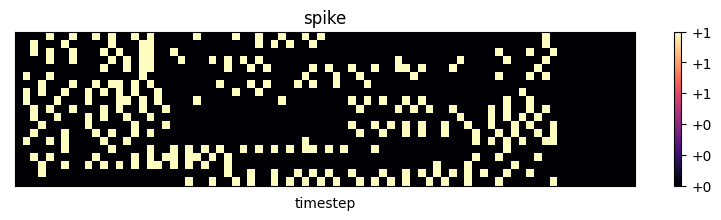

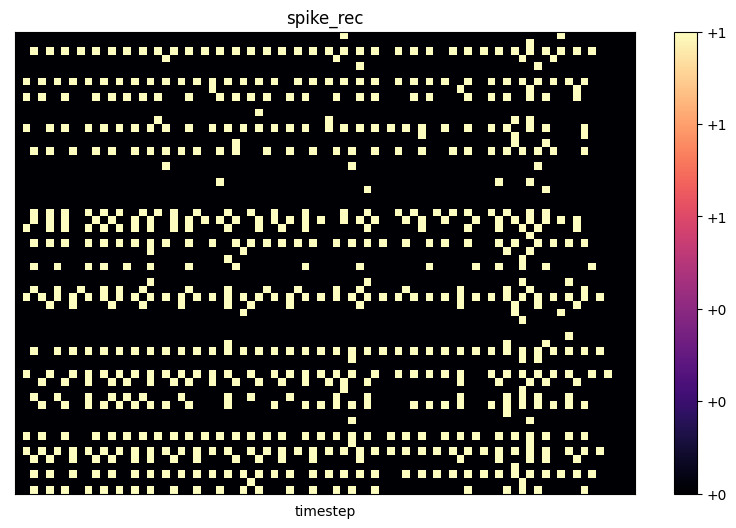

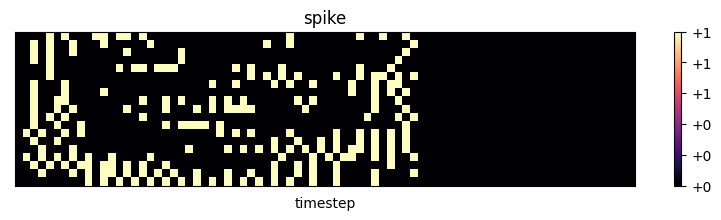

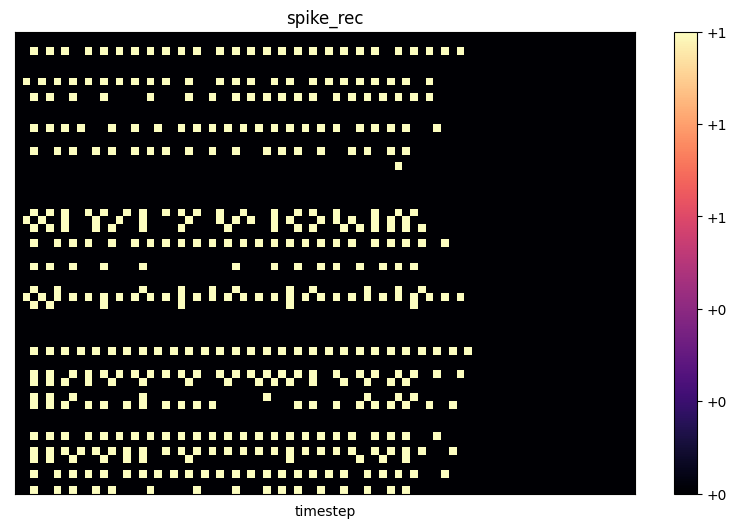

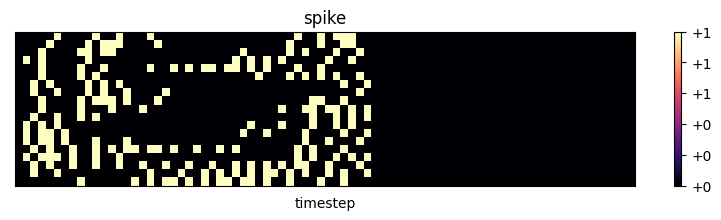

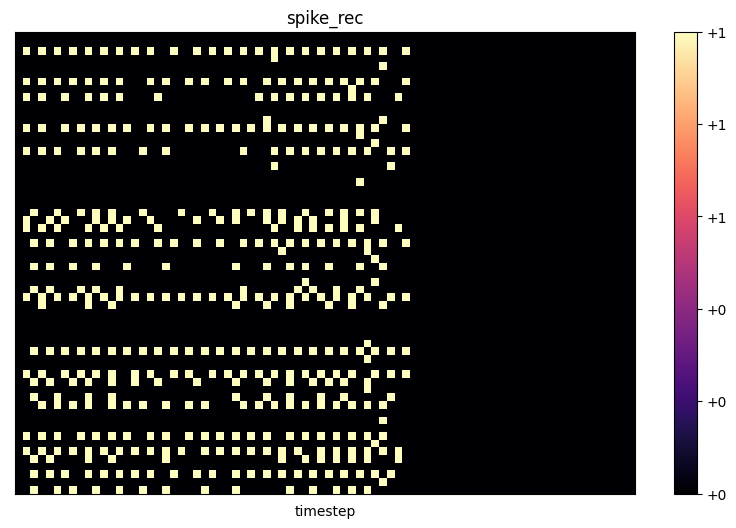

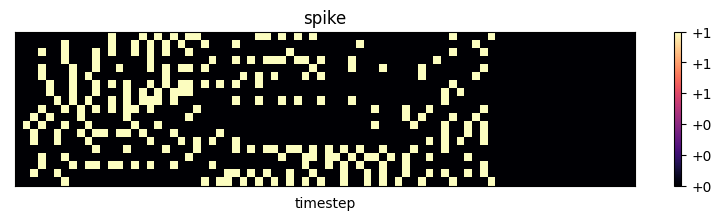

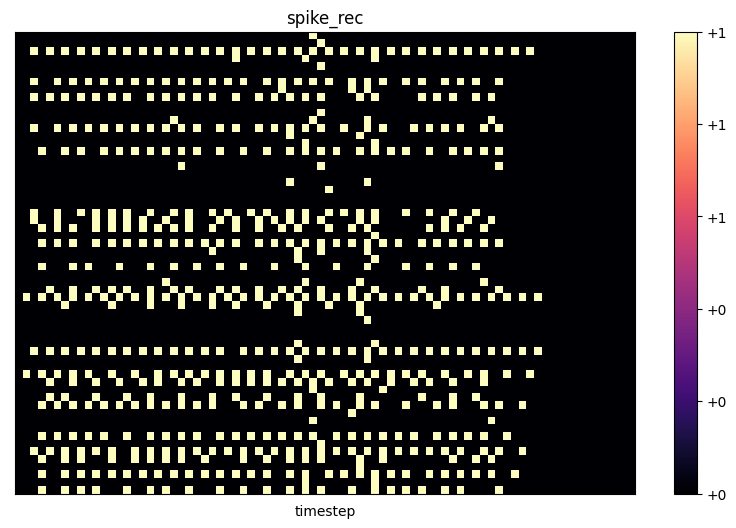

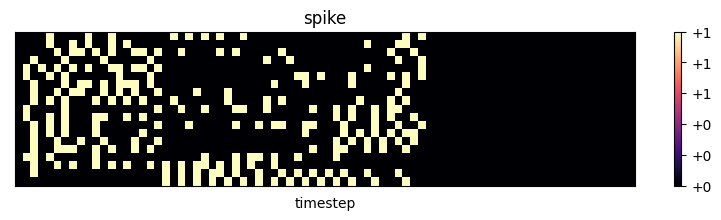

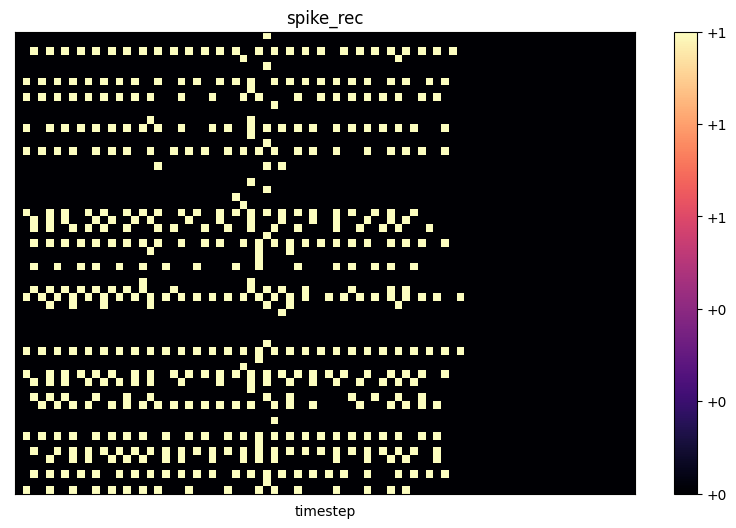

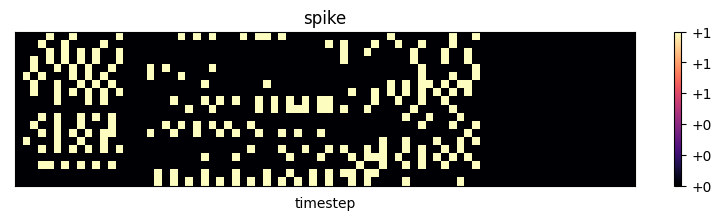

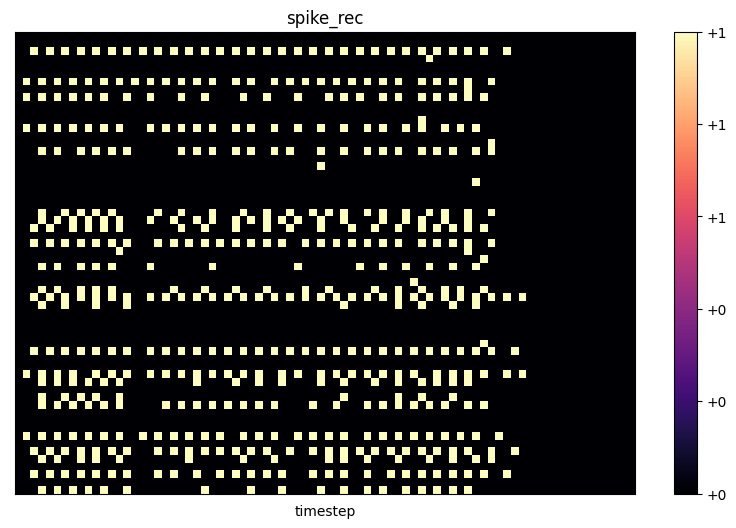

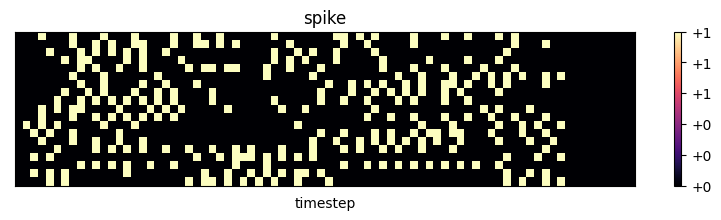

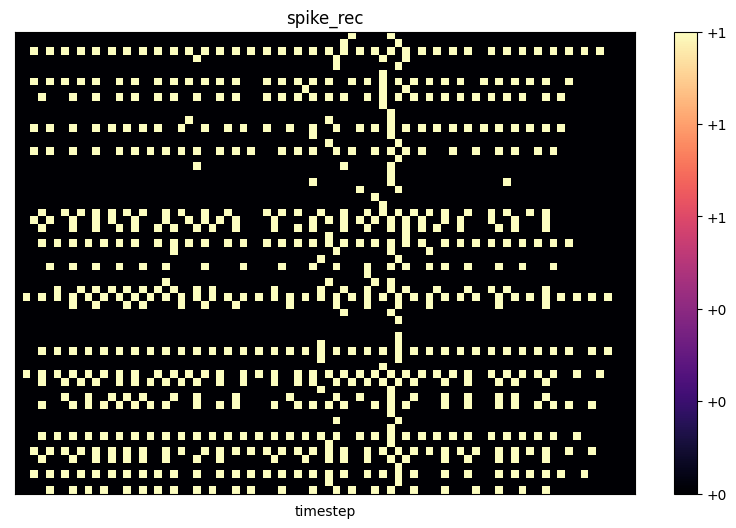

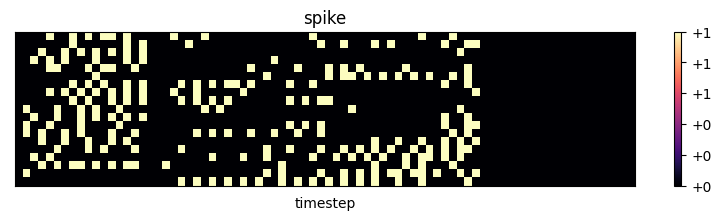

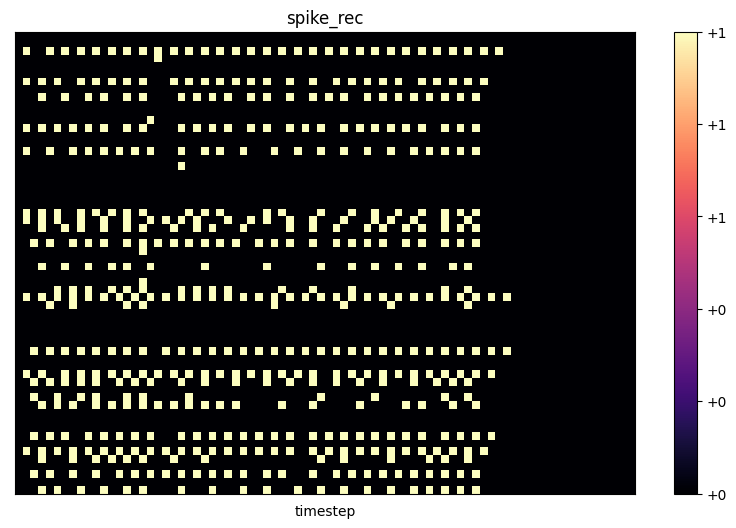

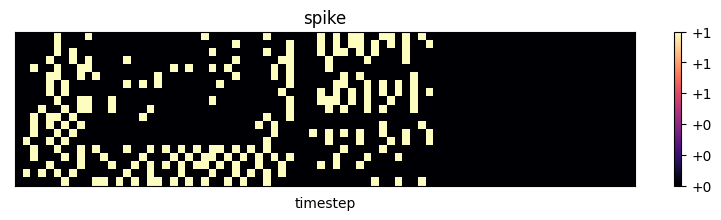

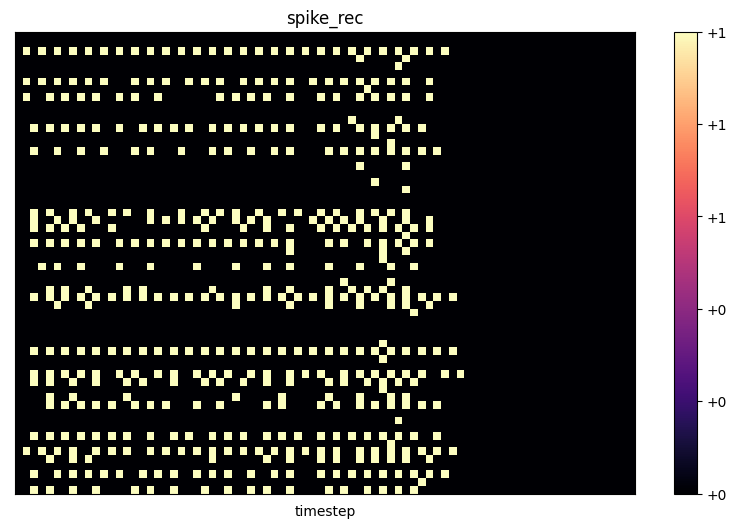

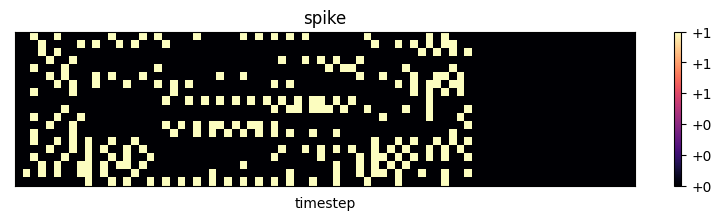

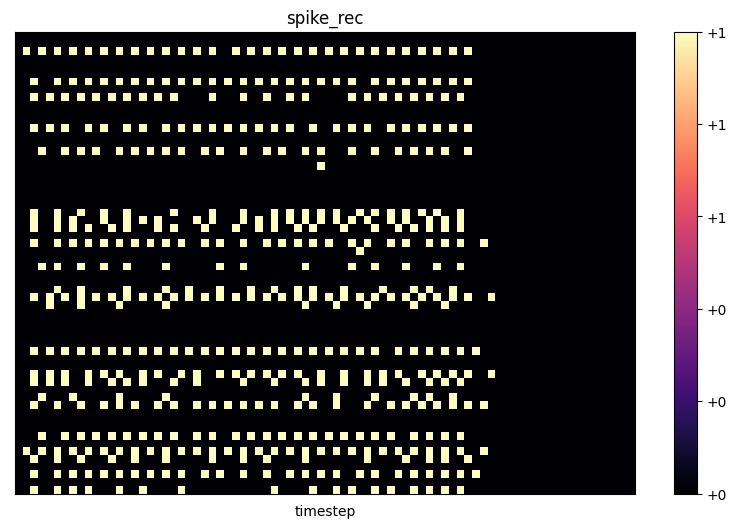

In [24]:
eval_env()